In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

from scipy import stats
from scipy.stats import skew, norm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold

# models
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso 

In [2]:
# set default parameters for figures
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5

mlp.rcParams['xtick.major.size'] = 20
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 20
mlp.rcParams['xtick.color'] = 'k'

mlp.rcParams['ytick.major.size'] = 20
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 20
mlp.rcParams['ytick.color'] = 'k'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = 'm'
mlp.rcParams['axes.labelcolor'] = 'm'

In [3]:
# loaging train data
train_dataset = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
train = train_dataset.copy()

# loading test data
test_dataset = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

print(f"Train's shape is {train_dataset.shape}, test's shape - {test_dataset.shape}")

Train's shape is (1460, 81), test's shape - (1459, 80)


 # **Feature preparation**

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Target 

In [5]:
train['SalePrice'].isna().sum()

0

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

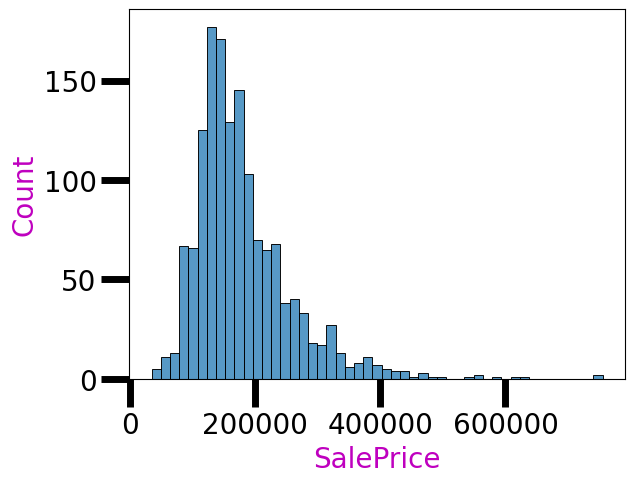

In [6]:
# look at the target
sns.histplot(data=train, x=train['SalePrice'])

In [7]:
print(train['SalePrice'].describe())
print()
print(f"Variance is {train['SalePrice'].var()}")

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Variance is 6311111264.297448


In [8]:
# the variance is too big, that means that the target has a large spread
# make logarithm tranformation

train = train.assign(LogSalePrice = np.log1p(train['SalePrice']))
train = train.drop('SalePrice', axis=1)

<AxesSubplot:xlabel='LogSalePrice', ylabel='Count'>

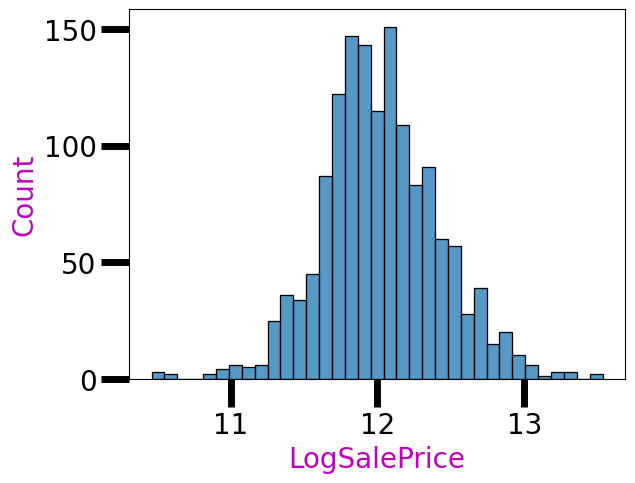

In [9]:
sns.histplot(data=train, x=train['LogSalePrice'])

In [10]:
# The Shapiro-Wilk test tests the null hypothesis that the
# data was taken from a normal distribution.

stats.shapiro(train['LogSalePrice'])[1]

# p-value is small => reject the H0, there is not a normal distribution

1.1467612637261482e-07

# Feature exploration

In [11]:
numeric_columns = train.loc[:,train.dtypes!=np.object].columns

# saving a list with columns which might be categorical and numerical at the same time.
# It's better to concern them as categorical
columns_both_types = ['MSSubClass','OverallQual', 'OverallCond']

numeric_columns = numeric_columns.drop(columns_both_types + ['LogSalePrice'])

train[numeric_columns].describe()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,70.049958,10516.828082,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,421.610009,24.284752,9981.264932,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,1.000000,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,365.750000,59.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,730.500000,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1095.250000,80.000000,11601.500000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [12]:
# check nulls
train[numeric_columns].isna().sum()[train[numeric_columns].isna().sum()>0].sort_values(ascending=False)

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64

In [13]:
# the functions below are userd for correlation analysis
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [14]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train[numeric_columns], 10))

Top Absolute Correlations
GarageCars    GarageArea      0.882475
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotalBsmtSF   1stFlrSF        0.819530
2ndFlrSF      GrLivArea       0.687501
BedroomAbvGr  TotRmsAbvGrd    0.676620
BsmtFinSF1    BsmtFullBath    0.649212
YearRemodAdd  GarageYrBlt     0.642277
GrLivArea     FullBath        0.630012
2ndFlrSF      TotRmsAbvGrd    0.616423
dtype: float64


In [15]:
# In the first model I've decided to get rid of features with corr > 0,8 using the function below.
# However, it appears that the model performance is better when they are included in training.

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

In [16]:
# Low variance can tell us that a variable may not be useful in models. Therefore, we may delete them. 
# But we should always think of the "meaning" of the variable.

# There are two numeric features with low var. I've decided to save them because of their 'meaning'.

cutter = VarianceThreshold(threshold=0.1)
cutter.fit(train[numeric_columns])
constant_cols = [x for x in numeric_columns if x not in cutter.get_feature_names_out()]

constant_cols

['BsmtHalfBath', 'KitchenAbvGr']

In [17]:
def prepare(df):
    '''
    This function prepares data. It cleans corrupted values, works with nulls 
    and changes columns' types
    '''
    
    # Change data types of numerical features that should be categorical
    columns_tochange_type = ['MSSubClass', 'YrSold',
                          'MoSold', 'OverallQual', 'OverallCond']
    for col in columns_tochange_type:
        df[col] = df[col].apply(str)
        
    
    ### Work with missing values    
    
    # Columns that can be filled with the most popular value
    for col in ['Functional', 'Electrical', 'KitchenQual', 
               'Exterior1st', 'Exterior2nd', 'SaleType']:
        df[col] = df[col].fillna(df[[col]].value_counts()[0])    
    
    # In these columns the missing values means that the house doesn't have such facility
    for col in ['GarageType','GarageFinish','GarageQual', 'GarageCond',
               'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        df[col] = df[col].fillna('None')

    # If there is no garage, there is a null in these cols => replace with 0
    for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
        df[col] = df[col].fillna(0)
               
    # Replace left nulls with None if the columns are categorical and with 0 for the numeric columns
    categorical_columns = list(df.loc[:,df.dtypes==np.object].columns)
    numeric_columns = list(df.loc[:,df.dtypes!=np.object].columns)

    for col in categorical_columns:
        df[col] = df[col].fillna('None')
    
    for col in numeric_columns:
        df[col] = df[col].fillna(0)
        
    
    # In the data description there is no value 'Brk Cmn'
    df['Exterior2nd'] = df['Exterior2nd'].replace({'Brk Cmn': 'BrkComm'})
    
    # I suppose that garage is usually built at the same year of a house construction or after
    df['GarageYrBlt'] = df['GarageYrBlt'].where(df.GarageYrBlt > df.YearBuilt, df.YearBuilt)
    
    # drop unnecessary columns
    df.drop(['Id', 'Utilities', 'Street', 'PoolQC', 
            'MiscFeature', 'MiscVal', 'YearRemodAdd'], axis=1, inplace = True)


In [18]:
def logarithm(df):
    '''
    Logarithm transformation is useful when we work with skewed data.
    This function takes log1p for numeric values that are skewed
    '''

    numeric_columns = list(df.loc[:,df.dtypes!=np.object].columns)

    skewed_columns = df[numeric_columns].apply(lambda x: skew(x)).sort_values(ascending=False)
    skewed_columns = skewed_columns[skewed_columns > 0.5]
    skewed_columns = list(skewed_columns.index)

    for col in skewed_columns:
        df[col] = np.log1p(df[col])

In [19]:
prepare(train)
logarithm(train)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MoSold,YrSold,SaleType,SaleCondition,LogSalePrice
0,60,RL,65.0,9.042040,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.283204,Gd,TA,PConc,Gd,TA,No,GLQ,6.561031,Unf,0.0,5.017280,6.753438,GasA,Ex,Y,SBrkr,6.753438,6.751101,0.0,7.444833,0.693147,0.000000,2,0.693147,3,0.693147,Gd,2.197225,Typ,0.000000,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0.000000,4.127134,0.000000,0.0,0.0,0.0,None,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9.169623,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,6.886532,Unf,0.0,5.652489,7.141245,GasA,Ex,Y,SBrkr,7.141245,0.000000,0.0,7.141245,0.000000,0.693147,2,0.000000,3,0.693147,TA,1.945910,Typ,0.693147,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,5.700444,0.000000,0.000000,0.0,0.0,0.0,None,5,2007,WD,Normal,12.109016
2,60,RL,68.0,9.328212,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.093750,Gd,TA,PConc,Gd,TA,Mn,GLQ,6.188264,Unf,0.0,6.075346,6.825460,GasA,Ex,Y,SBrkr,6.825460,6.765039,0.0,7.488294,0.693147,0.000000,2,0.693147,3,0.693147,Gd,1.945910,Typ,0.693147,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0.000000,3.761200,0.000000,0.0,0.0,0.0,None,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9.164401,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,5.379897,Unf,0.0,6.293419,6.629363,GasA,Gd,Y,SBrkr,6.869014,6.629363,0.0,7.448916,0.693147,0.000000,1,0.000000,3,0.693147,Gd,2.079442,Typ,0.693147,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0.000000,3.583519,5.609472,0.0,0.0,0.0,None,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,9.565284,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.860786,Gd,TA,PConc,Gd,TA,Av,GLQ,6.486161,Unf,0.0,6.196444,7.044033,GasA,Ex,Y,SBrkr,7.044033,6.960348,0.0,7.695758,0.693147,0.000000,2,0.693147,4,0.693147,Gd,2.302585,Typ,0.693147,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,5.262690,4.442651,0.000000,0.0,0.0,0.0,None,12,2008,WD,Normal,12.429220


In [20]:
# check if there are any nulls left
train.isnull().sum().sum()

0

In [21]:
def create_features(df):
    
    # creation of binary variables which mean the presence of a facility
    for col in ['2ndFlrSF', 'GarageArea', 'TotalBsmtSF', 'Fireplaces',
                'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'PoolArea',
                '3SsnPorch','ScreenPorch']:
        col_name = 'IsThere'+col
        df[col_name] = df[col].apply(lambda x: 1 if x > 0 else 0)
                
    # calculating some new features
    df["AvgFtPerRoom"] = df["GrLivArea"] / (
        df["TotRmsAbvGrd"] + df["FullBath"] + df["HalfBath"] + df["KitchenAbvGr"]
    )
    df['TotalFootage'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['BsmtFinSF1'] + df['BsmtFinSF2']
    df['TotalBathRooms'] = df['FullBath'] + df['BsmtFullBath'] + df['HalfBath']  + df['BsmtHalfBath']
    
    df['TotalPorch'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
    df['TotalQuality'] = df['OverallQual'] + df['OverallCond']

In [22]:
create_features(train)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MoSold,YrSold,SaleType,SaleCondition,LogSalePrice,IsThere2ndFlrSF,IsThereGarageArea,IsThereTotalBsmtSF,IsThereFireplaces,IsThereWoodDeckSF,IsThereOpenPorchSF,IsThereEnclosedPorch,IsTherePoolArea,IsThere3SsnPorch,IsThereScreenPorch,AvgFtPerRoom,TotalFootage,TotalBathRooms,TotalPorch,TotalQuality
0,60,RL,65.0,9.042040,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.283204,Gd,TA,PConc,Gd,TA,No,GLQ,6.561031,Unf,0.0,5.017280,6.753438,GasA,Ex,Y,SBrkr,6.753438,6.751101,0.0,7.444833,0.693147,0.000000,2,0.693147,3,0.693147,Gd,2.197225,Typ,0.000000,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0.000000,4.127134,0.000000,0.0,0.0,0.0,None,2,2008,WD,Normal,12.247699,1,1,1,0,0,1,0,0,0,0,1.333359,20.065570,3.386294,4.127134,75
1,20,RL,80.0,9.169623,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,6.886532,Unf,0.0,5.652489,7.141245,GasA,Ex,Y,SBrkr,7.141245,0.000000,0.0,7.141245,0.000000,0.693147,2,0.000000,3,0.693147,TA,1.945910,Typ,0.693147,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,5.700444,0.000000,0.000000,0.0,0.0,0.0,None,5,2007,WD,Normal,12.109016,0,1,1,1,1,0,0,0,0,0,1.539374,14.027777,2.693147,5.700444,68
2,60,RL,68.0,9.328212,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.093750,Gd,TA,PConc,Gd,TA,Mn,GLQ,6.188264,Unf,0.0,6.075346,6.825460,GasA,Ex,Y,SBrkr,6.825460,6.765039,0.0,7.488294,0.693147,0.000000,2,0.693147,3,0.693147,Gd,1.945910,Typ,0.693147,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0.000000,3.761200,0.000000,0.0,0.0,0.0,None,9,2008,WD,Normal,12.317171,1,1,1,1,0,1,0,0,0,0,1.404352,19.778763,3.386294,3.761200,75
3,70,RL,60.0,9.164401,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,5.379897,Unf,0.0,6.293419,6.629363,GasA,Gd,Y,SBrkr,6.869014,6.629363,0.0,7.448916,0.693147,0.000000,1,0.000000,3,0.693147,Gd,2.079442,Typ,0.693147,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0.000000,3.583519,5.609472,0.0,0.0,0.0,None,2,2006,WD,Abnorml,11.849405,1,1,1,1,0,1,1,0,0,0,1.974484,18.878275,1.693147,9.192991,75
4,60,RL,84.0,9.565284,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.860786,Gd,TA,PConc,Gd,TA,Av,GLQ,6.486161,Unf,0.0,6.196444,7.044033,GasA,Ex,Y,SBrkr,7.044033,6.960348,0.0,7.695758,0.693147,0.000000,2,0.693147,4,0.693147,Gd,2.302585,Typ,0.693147,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,5.262690,4.442651,0.000000,0.0,0.0,0.0,None,12,2008,WD,Normal,12.429220,1,1,1,1,1,1,0,0,0,0,1.352772,20.490541,3.386294,9.705341,85


In [23]:
def full_preparation(df, encode=0):
    
    prepare(df)
    logarithm(df)
    create_features(df)
    
    if encode==1:
        df = pd.get_dummies(df).reset_index(drop=True)
    
    return df

let's check some figures in order to check the visual correlation between categorical variables and target

In [24]:
categorical_columns = list(train.loc[:,train.dtypes==np.object].columns)

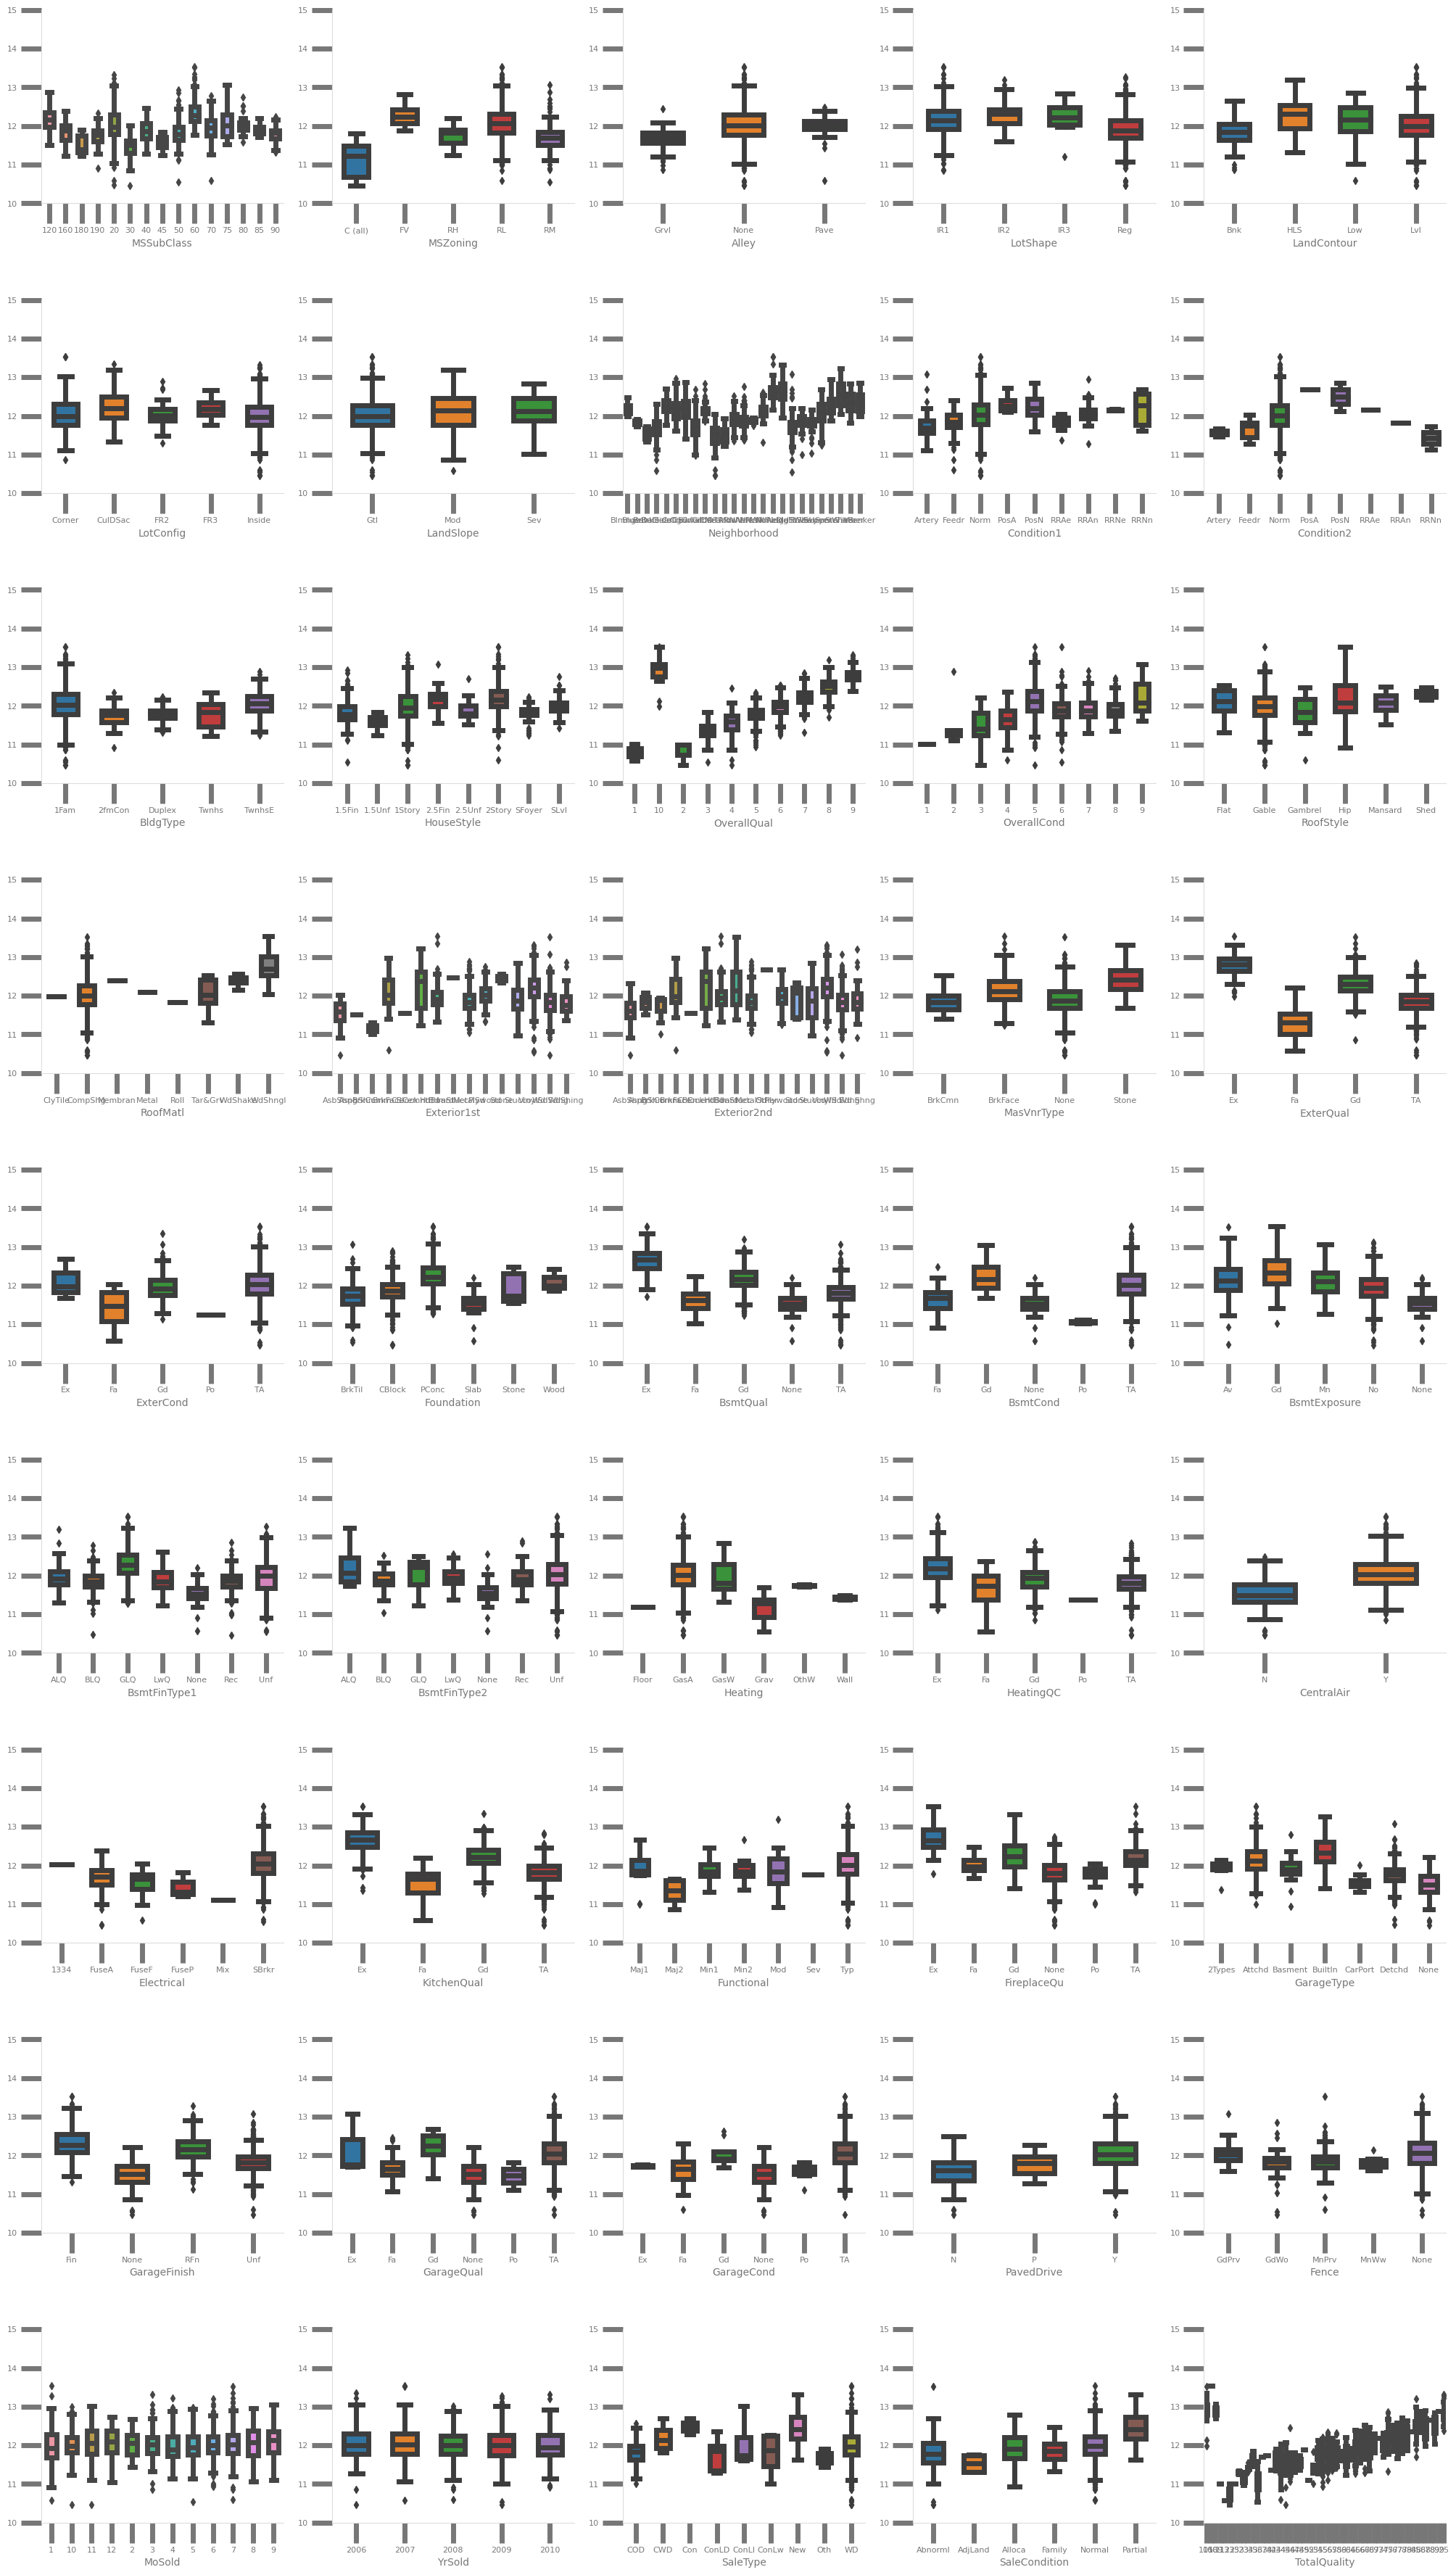

In [25]:
fig, axes = plt.subplots(nrows=9, ncols=5, figsize=(25, 45))

for i, col in enumerate(categorical_columns):
    ax = axes[i // 5, i % 5]
    sns.boxplot(y='LogSalePrice', x=train[col].astype('category'), data=train, ax=ax, width=0.5)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylim([10, 15])
    ax.tick_params(labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.spines['left'].set_color('#DDDDDD')
    ax.tick_params(axis='x', colors='#777777')
    ax.tick_params(axis='y', colors='#777777')
    ax.set_title('')
    ax.set_ylabel('')
    ax.xaxis.label.set_color('#777777')
    ax.yaxis.label.set_color('#777777')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(8)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(8)

plt.subplots_adjust(hspace=0.5)

plt.show()

it seems that LandSlope and YrSold may not be useful. Let's check it

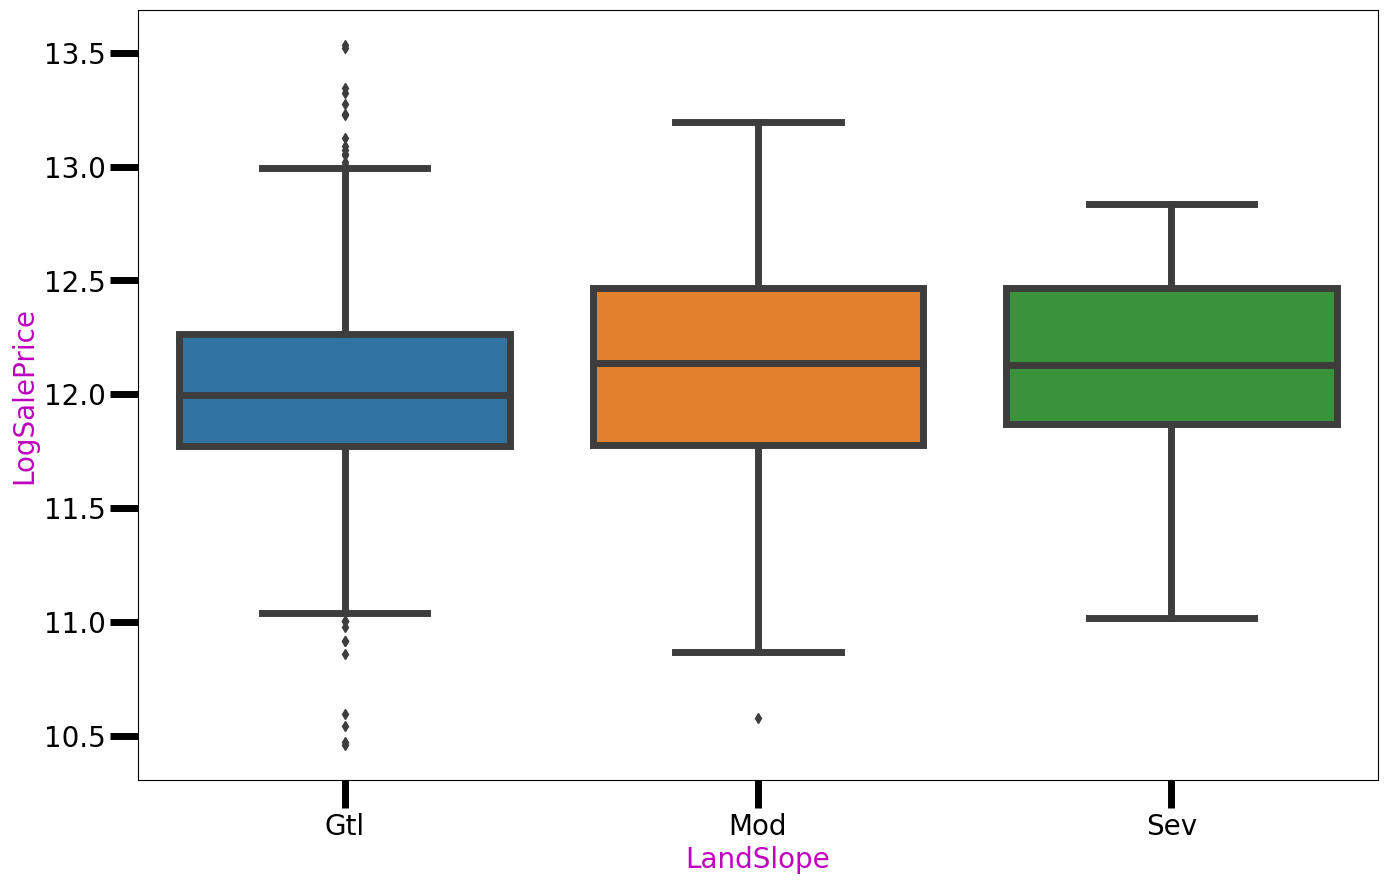

In [26]:
# There is a small difference with Gtl and others. I've decided to leave it

fig = plt.figure()
fig.set_size_inches(16, 10)
    
sns.boxplot(y='LogSalePrice', x=train['LandSlope'].astype('category'), data=train)
plt.show()

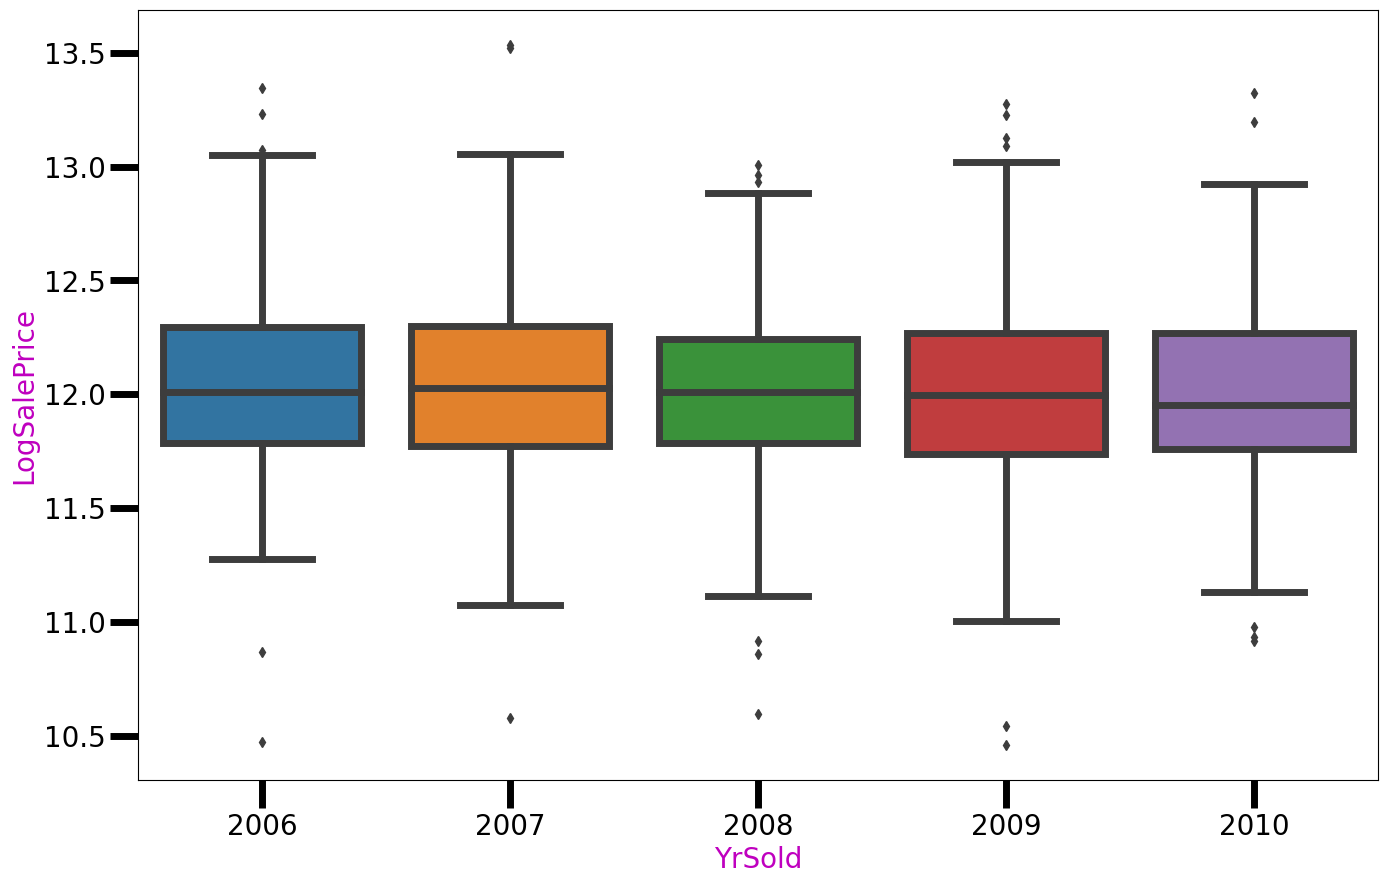

In [27]:
# There is a difference in spread of this variable. I've decided to leave it also
fig = plt.figure()
fig.set_size_inches(16, 10)
    
sns.boxplot(y='LogSalePrice', x=train['YrSold'].astype('category'), data=train)
plt.show()

# Models

In [28]:
train_rows = train_dataset.shape[0]

# Separate the target
y = train['LogSalePrice'].values 

# Create new dataset for modeling
data = pd.concat((train_dataset, test_dataset)).reset_index(drop=True)
data.drop(['SalePrice'], axis=1, inplace=True)

final_data = full_preparation(data, encode=1)
final_data.head()

,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,IsThere2ndFlrSF,IsThereGarageArea,IsThereTotalBsmtSF,IsThereFireplaces,IsThereWoodDeckSF,IsThereOpenPorchSF,IsThereEnclosedPorch,IsTherePoolArea,IsThere3SsnPorch,IsThereScreenPorch,AvgFtPerRoom,TotalFootage,TotalBathRooms,TotalPorch,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_1025,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_1014,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_

In [29]:
train = final_data[:train_rows]
test = final_data[train_rows:]
print(f"Train's shape: {train.shape}\nY_train's shape: {y.shape[0]}\nTest's shape: {test.shape}")

Train's shape: (1460, 416)
Y_train's shape: 1460
Test's shape: (1459, 416)


In [30]:
# In the competion RMSE is used as a primary metric

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=train):
    '''
    This function calculates rmse with cross validation 
    '''
    
    cv_result = cross_validate(model, X, y, 
                           scoring='neg_mean_squared_error',
                           cv=splitter, return_train_score=True)
    return cv_result

In [31]:
#define the splitter
splitter = KFold(n_splits=12, shuffle=True, random_state=42)

**CatBoostRegressor**

In [32]:
catboost = CatBoostRegressor(verbose=False)

print(f"Catboost RMSE with cv on train folds: {-np.mean(cv_rmse(catboost)['train_score']).round(3)}")
print(f"Catboost RMSE with cv on test folds: {-np.mean(cv_rmse(catboost)['test_score']).round(3)}")

catboost.fit(train,y)
print(f"Catboost RMSE on the whole train data = {rmse(y, catboost.predict(train))}")

Catboost RMSE with cv on train folds: 0.001
Catboost RMSE with cv on test folds: 0.016
Catboost RMSE on the whole train data = 0.03836759801160792


**Lasso**

In [33]:
lasso = Lasso(max_iter=100000)

print(f"Lasso RMSE with cv on train folds: {-np.mean(cv_rmse(lasso)['train_score']).round(3)}")
print(f"Lasso RMSE with cv on test folds: {-np.mean(cv_rmse(lasso)['test_score']).round(3)}")

lasso.fit(train,y)
print(f"Lasso RMSE on the whole train data = {rmse(y, lasso.predict(train))}")

Lasso RMSE with cv on train folds: 0.078
Lasso RMSE with cv on test folds: 0.078
Lasso RMSE on the whole train data = 0.2784413697235146


**XGBRegressor**

In [34]:
xgb = XGBRegressor()

print(f"XGBoost RMSE with cv on train folds: {-np.mean(cv_rmse(xgb)['train_score']).round(3)}")
print(f"XGBoost RMSE with cv on test folds: {-np.mean(cv_rmse(xgb)['test_score']).round(3)}")

xgb.fit(train,y)
print(f"XGBoost RMSE on the whole train data = {rmse(y, xgb.predict(train))}")

XGBoost RMSE with cv on train folds: 0.0
XGBoost RMSE with cv on test folds: 0.02
XGBoost RMSE on the whole train data = 0.011727935414063296


**LGBMRegressor**

In [35]:
lgb = LGBMRegressor()

print(f"LGBM RMSE with cv on train folds: {-np.mean(cv_rmse(lgb)['train_score']).round(3)}")
print(f"LGBM RMSE with cv on test folds: {-np.mean(cv_rmse(lgb)['test_score']).round(3)}")

lgb.fit(train,y)
print(f"LGBM RMSE on the whole train data = {rmse(y, lgb.predict(train))}")

LGBM RMSE with cv on train folds: 0.002
LGBM RMSE with cv on test folds: 0.019
LGBM RMSE on the whole train data = 0.04760601124856381


# Performance improvement

In [36]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)

**Lasso**

In [37]:
alphas = np.linspace(start=0.01, stop=1, num=30)

param_grid = {
    "alpha": alphas
}

search = GridSearchCV(lasso, param_grid, 
                      cv=splitter, scoring='neg_mean_squared_error')

search.fit(X_train,y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

lasso.set_params(alpha=search.best_params_['alpha'])

y_pred = lasso.predict(X_test)

print("RMSE:", rmse(y_test, y_pred))

Best parameter (CV score=-0.03034):
{'alpha': 0.01}
RMSE: 0.3053732666159735


In [38]:
print(f"Lasso RMSE with cv on train folds: {-np.mean(cv_rmse(lasso)['train_score']).round(3)}")
print(f"Lasso RMSE with cv on test folds: {-np.mean(cv_rmse(lasso)['test_score']).round(3)}")

lasso.fit(train,y)
print(f"Lasso RMSE on the whole train data = {rmse(y, lasso.predict(train))}")

Lasso RMSE with cv on train folds: 0.029
Lasso RMSE with cv on test folds: 0.03
Lasso RMSE on the whole train data = 0.17105228699683694


**CatBoostRegressor**

In [39]:
# This section performs a grid search over hyperparameters for my model, which can be quite time-consuming.
# For this reason, I am commenting it out in the final version of my script to save time when running the entire script.
# Note that this section was originally run on a separate occasion using a GPU for faster processing.

# cat = CatBoostRegressor()

# # set the grid of hyperparameters
# param_grid = {
#     'iterations' : [2000, 4000, 6000],
#     'learning_rate': [0.005, 0.01, 0.05],
#     'depth': [3, 4, 5], 
#     'l2_leaf_reg': [1,2],
#     'eval_metric': ['RMSE']    
# }

# grid_search = GridSearchCV(cat, param_grid=param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)

In [40]:
cat = CatBoostRegressor(iterations = 6000,
                        learning_rate = 0.005,
                        depth = 4,
                        l2_leaf_reg = 1,
                        eval_metric = 'RMSE',
                        random_seed = 42,
                        logging_level = 'Silent'
                       )

cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)

print("New Catboost RMSE:", rmse(y_test, y_pred))

New Catboost RMSE: 0.1320671742455505


In [41]:
print(f"Catboost RMSE with cv on train folds: {-np.mean(cv_rmse(cat)['train_score']).round(3)}")
print(f"Catboost RMSE with cv on test folds: {-np.mean(cv_rmse(cat)['test_score']).round(3)}")

cat.fit(train,y)
print(f"Catboost RMSE on the whole train data = {rmse(y, cat.predict(train))}")

Catboost RMSE with cv on train folds: 0.004
Catboost RMSE with cv on test folds: 0.015
Catboost RMSE on the whole train data = 0.06441646648320733


**XGBRegressor**

In [42]:
# This section performs a grid search over hyperparameters for my model, which can be quite time-consuming.
# For this reason, I am commenting it out in the final version of my script to save time when running the entire script.
# Note that this section was originally run on a separate occasion using a GPU for faster processing.

# xgb = XGBRegressor()

# # set the grid of hyperparameters
# param_grid = {
#     'n_estimators' : [1000, 2000, 3000],
#     'learning_rate': [0.005, 0.01, 0.03],
#     'max_depth': [3, 4, 5] 
# }

# grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)

In [43]:
xgboost = XGBRegressor(n_estimators=2000,
                       learning_rate=0.03,
                       max_depth=4,
                       random_state = 42)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("New XGBoost RMSE:", rmse(y_test, y_pred))

New XGBoost RMSE: 0.1556792166204395


In [44]:
print(f"XGBoost RMSE with cv on train folds: {-np.mean(cv_rmse(xgb)['train_score']).round(3)}")
print(f"XGBoost RMSE with cv on test folds: {-np.mean(cv_rmse(xgb)['test_score']).round(3)}")

xgb.fit(train,y)
print(f"XGBoost RMSE on the whole train data = {rmse(y, xgb.predict(train))}")

XGBoost RMSE with cv on train folds: 0.0
XGBoost RMSE with cv on test folds: 0.02
XGBoost RMSE on the whole train data = 0.011727935414063296


In [45]:
# let's look at the importance of variables to assess the contribution of each
def get_feature_importance(importance,names):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    return fi_df

I've decided to work only with cat and xbg because on average their performance is better

In [46]:
cat_features_importance = get_feature_importance(cat.feature_importances_,train.columns)
xgboost_features_importance = get_feature_importance(xgb.feature_importances_,train.columns)

both_features = pd.merge(
    xgboost_features_importance, cat_features_importance, 
    how='inner', on='feature_names')

both_features.sort_values(['feature_importance_x', 'feature_importance_y'], ascending=False).head()

,feature_names,feature_importance_x,feature_importance_y
0,BsmtQual_Ex,0.144704,1.443814
1,GarageCars,0.068649,4.184954
2,KitchenQual_Ex,0.062457,1.292102
3,KitchenQual_TA,0.054205,1.366388
4,TotalBathRooms,0.037988,5.538712


In [47]:
# find features that appeared less imformative in both models 
columns_to_drop = list(both_features[
    (both_features['feature_importance_x']<=0.0001)&(both_features['feature_importance_y']<=0.0001)
]['feature_names'])

In [48]:
# create new sets without "useless" features
train_new = train.drop(columns_to_drop, axis=1)
test_new = test.drop(columns_to_drop, axis=1)

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(train_new, y, test_size=0.2, random_state=42)

In [49]:
cat_2 = CatBoostRegressor(iterations = 6000,
                               learning_rate = 0.005,
                               depth = 4,
                               l2_leaf_reg = 1,
                               eval_metric = 'RMSE',
                               random_seed = 42,
                               logging_level = 'Silent')
cat_2.fit(X_train, y_train)
y_pred = cat_2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("New CatBoost RMSE:", rmse)

New CatBoost RMSE: 0.13183384020359698


In [50]:
xgboost_2 = XGBRegressor(n_estimators=2000,
                       learning_rate=0.03,
                       max_depth=4,
                       random_state = 42)
xgboost_2.fit(X_train, y_train)
y_pred = xgboost_2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("New XGBoost RMSE:", rmse)

New XGBoost RMSE: 0.14645027786772663


# Anomaly detection

In [51]:
data = pd.concat((train, pd.DataFrame(y)), axis=1).rename(columns={0:'LogSalePrice'})

In [52]:
data.head()

,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,IsThere2ndFlrSF,IsThereGarageArea,IsThereTotalBsmtSF,IsThereFireplaces,IsThereWoodDeckSF,IsThereOpenPorchSF,IsThereEnclosedPorch,IsTherePoolArea,IsThere3SsnPorch,IsThereScreenPorch,AvgFtPerRoom,TotalFootage,TotalBathRooms,TotalPorch,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_1025,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_1014,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_

In [53]:
top_quantile = data['LogSalePrice'].quantile(0.975)
low_quantile = data['LogSalePrice'].quantile(0.025)

print(f"Top 2,5% target values: {top_quantile.round(2)}")
print(f"Top 97,5% target values: {low_quantile.round(2)}")

Top 2,5% target values: 12.86
Top 97,5% target values: 11.29


In [54]:
# Delete anomal objects [top 2,5%; top97,5%]

data = data[(data['LogSalePrice']>low_quantile)&(data['LogSalePrice']<top_quantile)]

X_new, Y_new = data.drop('LogSalePrice', axis=1), data['LogSalePrice']

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=42)

In [55]:
cat_3 = CatBoostRegressor(iterations = 6000,
                               learning_rate = 0.005,
                               depth = 4,
                               l2_leaf_reg = 1,
                               eval_metric = 'RMSE',
                               random_seed = 11,
                               logging_level = 'Silent')
cat_3.fit(X_train, y_train)
y_pred = cat_3.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("New CatBoost RMSE:", rmse)

New CatBoost RMSE: 0.1088335191116972


In [56]:
xgboost_3 = XGBRegressor(n_estimators=2000,
                       learning_rate=0.03,
                       max_depth=4,
                       random_state = 42)
xgboost_3.fit(X_train, y_train)
y_pred = xgboost_3.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 0.11008293751331731


In [57]:
xgboost_3.fit(train_new,y)
xgb_y_pred = xgboost_2.predict(test_new)

In [58]:
cat_3.fit(train_new,y)
cat_y_pred = cat_3.predict(test_new)

# Final preds

In [59]:
# I've decided to take avg from xgb and cat predictions.
preds = ((xgb_y_pred+cat_y_pred)/2)
preds

array([11.78906129, 11.98676513, 12.17605465, ..., 11.88926805,
       11.67864422, 12.29298888])

In [60]:
answer = pd.concat((test_dataset['Id'], pd.DataFrame(preds)), axis=1).set_index('Id')
answer = answer.rename(columns={0:'SalePrice'})
answer['SalePrice'] = np.expm1(answer['SalePrice'])
answer.head()

,SalePrice
Id,
1461,131801.687174
1462,160613.944626
1463,194084.613897
1464,200622.325562
1465,190317.195230


In [61]:
# answer.to_csv('house_pricing.csv')

The final score on Kaggle is 0.12316